# Brett's GNOD Project

Disclaimer: These labs have been completed with limited time. I am aware of the large amount of refactoring and optimizing that can be done, but I would rather bring these up with a TA.

1. Standardizing Function not working as function, needing to do it manually
2. Creating Modules and Loading from Other Notebooks
3. General Cleanliness and Functions w/ local variables
4. Potential to return duplicates from either cluster or billboard top 100

In [2]:
#Import Packages
import pandas as pd
from bs4 import BeautifulSoup
import requests


# Billboard Top 100

In [3]:
# Create response and check response status code
url = "https://www.billboard.com/charts/hot-100"
response = requests.get(url)
soup= BeautifulSoup (response.content,"html.parser")
response.status_code

200

In [4]:
#Create Lists for what we will be scraping

ranking = [] 
titles = [] 
artists = [] 
last_week = [] 
peak_ranks = [] 
weeks_on_chart = []


In [5]:
#For Loop to Scrape Desired Data from Site Tags

for tag in soup.select("div > ol > li > button"):
    
    ranking.append(tag.find("span",class_= "chart-element__rank__number").get_text())
    titles.append(tag.find("span",class_= "chart-element__information__song text--truncate color--primary").get_text())
    artists.append(tag.find("span",class_= "chart-element__information__artist text--truncate color--secondary").get_text())
    last_week.append(tag.find("span",class_ = "chart-element__meta text--center color--secondary text--last").get_text())
    peak_ranks.append(tag.find("span",class_= "chart-element__meta text--center color--secondary text--peak").get_text())
    weeks_on_chart.append(tag.find("span",class_= "chart-element__meta text--center color--secondary text--week").get_text())

In [6]:
#Create DF from Dictionary
billboard = pd.DataFrame({ "Billboard Rank": ranking, "Title":titles, "Artists":artists, "Weeks on Chart": weeks_on_chart, "Last Weeks Rank": last_week, "Highest Rank": peak_ranks})

billboard.head()

,Billboard Rank,Title,Artists,Weeks on Chart,Last Weeks Rank,Highest Rank
0,1,Drivers License,Olivia Rodrigo,6,1,1
1,2,34+35,Ariana Grande,16,6,2
2,3,Calling My Phone,Lil Tjay Featuring 6LACK,1,-,3
3,4,Blinding Lights,The Weeknd,63,3,1
4,5,Up,Cardi B,2,2,2


# Spotify DataFrame

In [7]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= "33f0230d3b6146bba6504b2cc1cbcf80" , client_secret="153b8c79aee54d7bb62ee64c927b0fb2" ))

In [8]:
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [9]:
def playlist_dataframe(creator, playlist_id):
    
    # Create List of Columns
    playlist_features_list = ["artist", "album", "track_name", "track_id", "danceability", "energy", "key", "loudness", "mode", "speechiness","acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
    
    #Apply Column Names
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Create Empty Dict
    playlist_features = {}
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    
    #Create the Loop to Acquire Playlist Data
    for track in playlist:
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        # Create Audio Feature DataFrame
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        
        #Create Audio Feature For Loop
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concatenate the DataFrames
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
    
    #return Playlist in DataFrame    
    return playlist_df

In [10]:
#Create Initial Playlist DataFrame
playlist_dataframe('12184874172', '3pzMSqFa0xKyTg0bPizs3K')

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Tash Sultana,Terra Firma,Coma,1UTLAJpm7M7JiAT23qTy08,0.236,0.525,1,-8.233,0,0.0356,0.51000,0.541000,0.1370,0.0773,135.839,332488,4
1,Besomorph,Wilted,Wilted,2C1Zh4eh7M07Hlx97zYVgF,0.507,0.695,6,-8.441,0,0.0508,0.02130,0.001390,0.0892,0.5440,95.012,188211,4
2,Fall Out Boy,Folie à Deux,I Don't Care - Single Version,7ewT0nLFkMD8ONbRibePr9,0.550,0.938,11,-3.556,0,0.0522,0.00171,0.000022,0.5550,0.4330,133.990,214493,4
3,Charlie Cunningham,Permanent Way,Permanent Way,4ewgXAEfRGjay6kmYSfbfW,0.561,0.550,8,-17.419,1,0.0370,0.77000,0.476000,0.0921,0.4460,147.010,252080,4
4,Oh Wonder,Home Tapes,I Like It When You Love Me,6UiS2IW9dEZwC6TluY5zSy,0.481,0.432,5,-11.982,0,0.3830,0.82400,0.000347,0.1050,0.1940,83.595,226560,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,More Giraffes,Dinosaur (OTR Remix),Dinosaur - OTR Remix,6PsPrBPvWqyhRCFVIxfCkg,0.526,0.553,9,-6.389,1,0.1070,0.20100,0.066100,0.1080,0.2090,78.901,183797,4
96,Paul Desmond,Greatest Hits Series--Paul Desmond,A Taste of Honey - Live,6PdC87pNlAOBZFRVhk2c3Q,0.492,0.151,5,-18.015,0,0.0421,0.91800,0.003530,0.1100,0.2150,124.925,271000,3
97,Shirley Bassey,And I Love You So,Jezahel - 2000 Remaster,2w4vN7AiWqmwDl5Mk1La61,0.555,0.569,1,-7.739,0,0.0361,0.38400,0.027800,0.7190,0.7440,109.027,170427,4
98,Julie London,"Yummy, Yummy, Yummy",Light My Fire,0YfMaGevOvsYZ3rihLvJzr,0.363,0.404,10,-11.579,1,0.0311,0.61800,0.010500,0.3210,0.3610,165.843,202413,4


In [11]:
#Create Dictionary of Playlists, to be concatednated later
playlist_dict = {
    "Library 854" : ("Brett Hunt", "3pzMSqFa0xKyTg0bPizs3K"), 
    "Geek Music" : ("Clement Patin", "7duhD5vDd0IOBoRck8godM"),
    "Girly Pop Hype" : ("Danielle Nicole Johnson", "7ht7e7WWZzkA9QkqXjQDXn"),
    "Fortnite Radio Tracks" : ('GabrielNRG', '057sHAhfWopSFSA75BAk24'),
    "The 50s and 60s, Golden Oldies" : ('John Peter Furst', '5tz0Cp0HWIMCiEGoswjMP8'),
    "All out 70s" : ('Spotify', '37i9dQZF1DWTJ7xPn4vNaz'),
    "80s Hits" : ('spotify', '37i9dQZF1DXb57FjYWz00c'),
    "All out 90s" : ('spotify', '37i9dQZF1DXbTxeAdrVG2l'),
}

In [12]:
def playlist_dataframe_concat(playlist_dict):
    # Loop through every playlist in the dict and create a DataFrame for it, using the Keys and Values of the Dictionary - without key/val enumerate will provide the wrong outputs
    for i, (key, val) in enumerate(playlist_dict.items()):
        
        playlist_df = playlist_dataframe(*val)
        
        # Add a playlist column so that we can see which playlist a track belongs too
        playlist_df["playlist"] = key
        
        # Create or concatenate dataframes
        if i == 0:
            playlist_dict_df = playlist_df
        else:
            playlist_dict_df = pd.concat([playlist_dict_df, playlist_df], ignore_index = True)
            
    return playlist_dict_df

In [13]:
music = playlist_dataframe_concat(playlist_dict)
music["playlist"].value_counts()

The 50s and 60s, Golden Oldies    100
80s Hits                          100
Library 854                       100
Girly Pop Hype                    100
All out 90s                       100
All out 70s                       100
Geek Music                         88
Fortnite Radio Tracks              68
Name: playlist, dtype: int64

In [14]:
music.shape

(756, 18)

In [15]:
music.head()

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,playlist
0,Tash Sultana,Terra Firma,Coma,1UTLAJpm7M7JiAT23qTy08,0.236,0.525,1,-8.233,0,0.0356,0.51000,0.541,0.1370,0.0773,135.839,332488,4,Library 854
1,Besomorph,Wilted,Wilted,2C1Zh4eh7M07Hlx97zYVgF,0.507,0.695,6,-8.441,0,0.0508,0.02130,0.00139,0.0892,0.5440,95.012,188211,4,Library 854
2,Fall Out Boy,Folie à Deux,I Don't Care - Single Version,7ewT0nLFkMD8ONbRibePr9,0.550,0.938,11,-3.556,0,0.0522,0.00171,2.18e-05,0.5550,0.4330,133.990,214493,4,Library 854
3,Charlie Cunningham,Permanent Way,Permanent Way,4ewgXAEfRGjay6kmYSfbfW,0.561,0.550,8,-17.419,1,0.0370,0.77000,0.476,0.0921,0.4460,147.010,252080,4,Library 854
4,Oh Wonder,Home Tapes,I Like It When You Love Me,6UiS2IW9dEZwC6TluY5zSy,0.481,0.432,5,-11.982,0,0.3830,0.82400,0.000347,0.1050,0.1940,83.595,226560,4,Library 854


In [54]:
music_prep = music.drop(['artist','album', 'track_name', 'track_id', 'playlist'], axis=1)

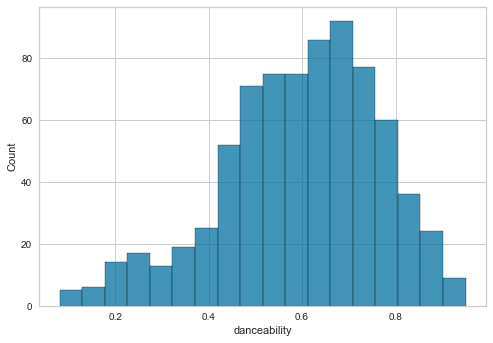

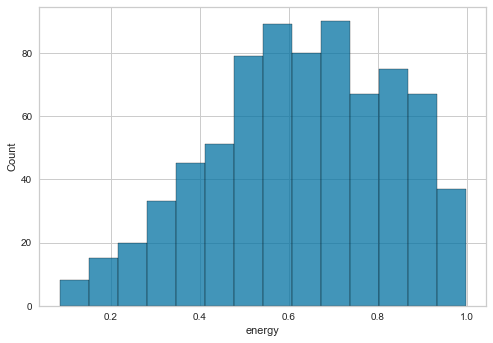

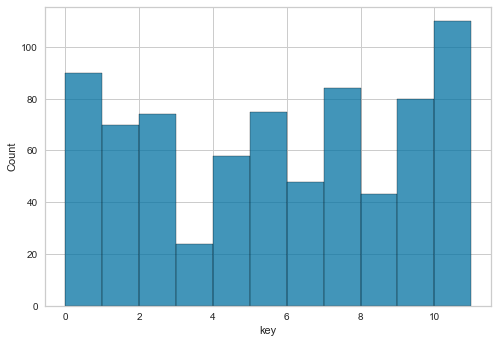

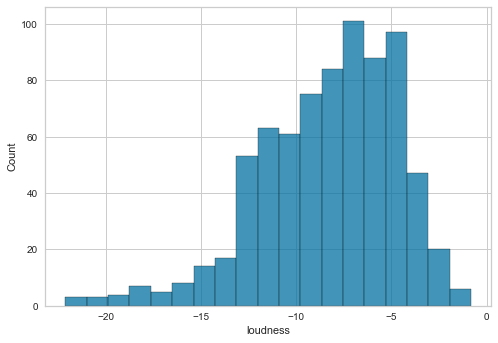

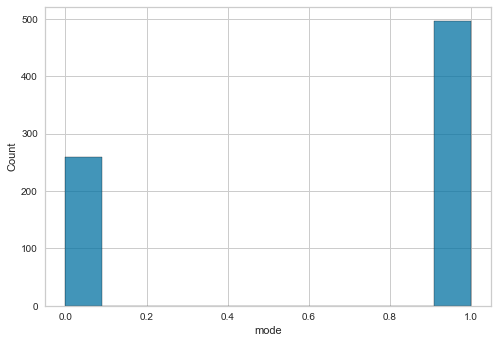

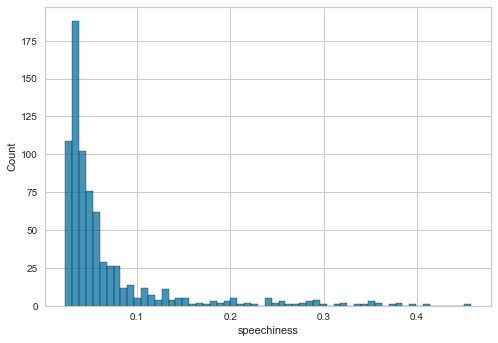

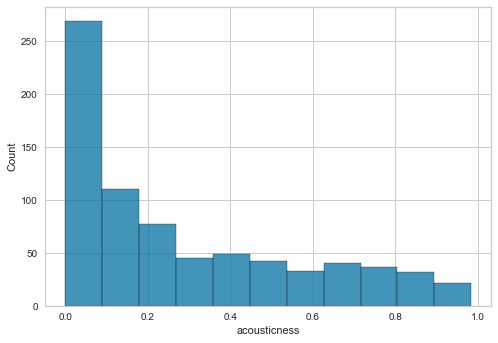

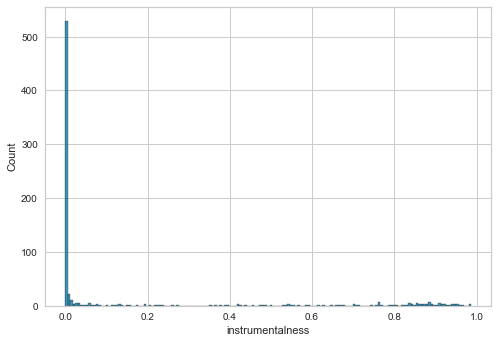

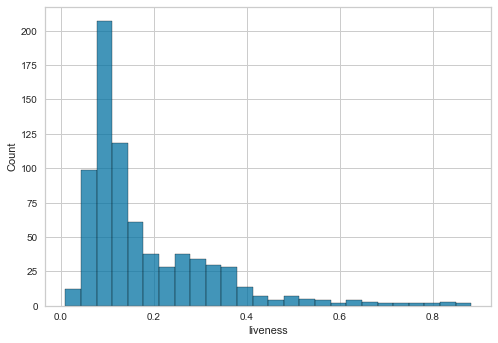

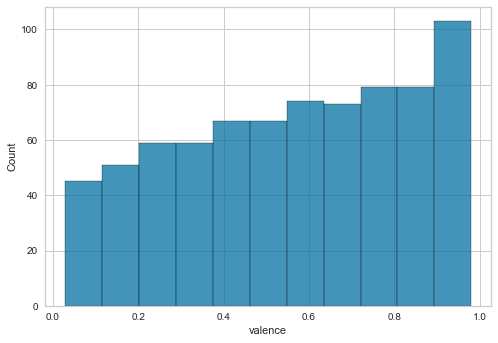

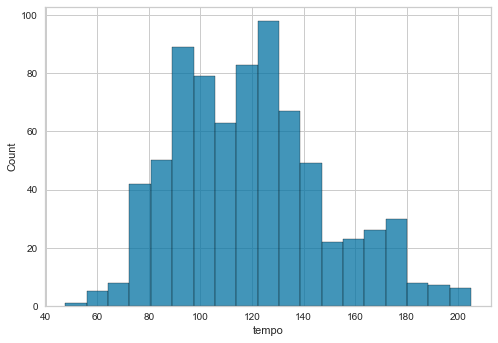

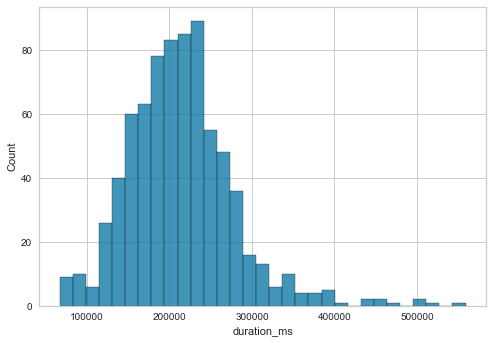

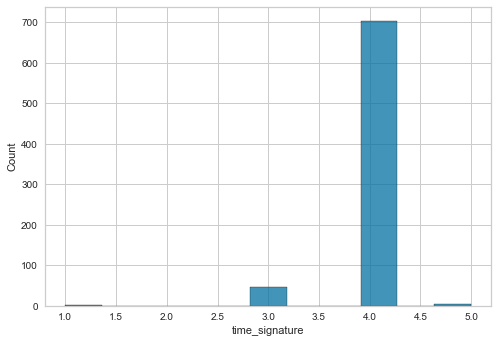

In [130]:
import seaborn as sns
for feature in music_prep.columns:
    sns.histplot(music[feature])
    plt.show()

# K Means

In [ ]:
from sklearn.preprocessing import StandardScaler

In [153]:
X_num = music_prep
transformer = StandardScaler().fit(X_num)
x_standardized = transformer.transform(X_num)
print(x_standardized.shape)

(756, 13)


array([[-2.14265384e+00, -5.03296384e-01, -1.20575621e+00, ...,
         5.55596295e-01,  1.82129180e+00,  2.10285039e-01],
       [-5.35446944e-01,  3.32628946e-01,  2.03569230e-01, ...,
        -8.44128099e-01, -4.04596787e-01,  2.10285039e-01],
       [-2.80428876e-01,  1.52751045e+00,  1.61289467e+00, ...,
         4.92204657e-01,  8.78817892e-04,  2.10285039e-01],
       ...,
       [-1.27084788e+00,  1.70361088e-01, -9.23891123e-01, ...,
         5.21316094e-02,  1.30094018e+00,  2.10285039e-01],
       [ 1.82162039e-01,  1.60126856e+00,  1.33102958e+00, ...,
        -2.91396899e-01,  2.15002397e-01,  2.10285039e-01],
       [ 1.32084737e+00,  1.52259324e+00, -7.82958578e-02, ...,
         3.89900359e-01,  3.67044178e-01,  2.10285039e-01]])

## Inertia

Text(0.5, 1.0, 'Elbow Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

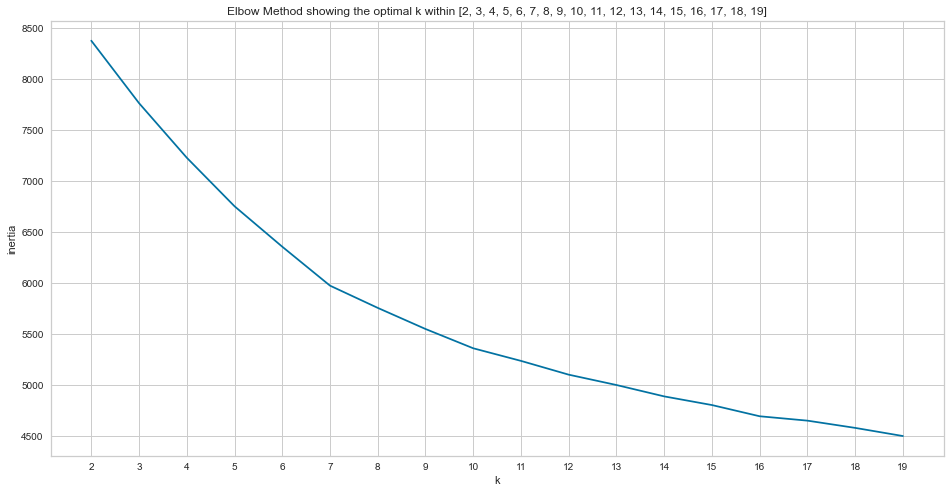

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
K = range(2,20)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                random_state=1234,
                n_init=20,
                algorithm='elkan',
                max_iter=25)
    kmeans.fit(x_standardized)
    inertias.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')

## Silhouette

Text(0.5, 1.0, 'Elbow Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

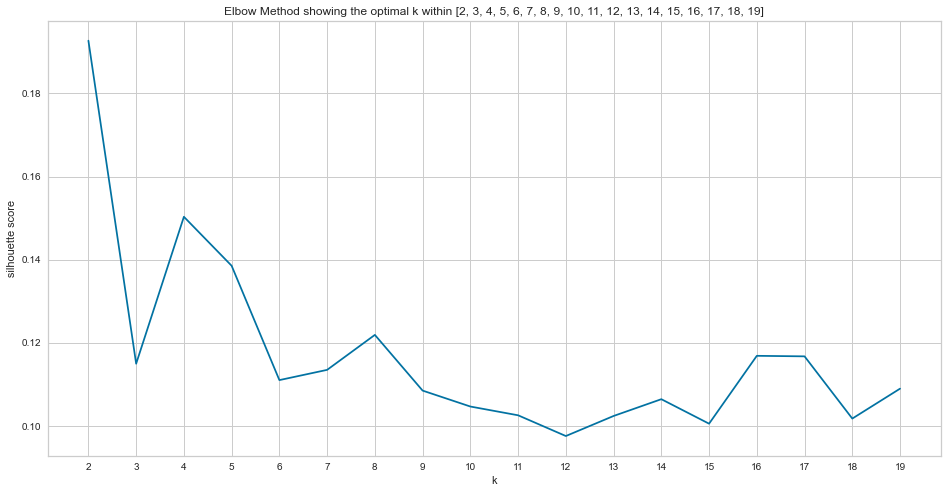

In [155]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
K = range(2,20)
silhouettes = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                random_state=1234,
                n_init=10,
                algorithm='elkan',
                max_iter=10)
    kmeans.fit(x_standardized)
    silhouettes.append(silhouette_score(x_standardized, kmeans.predict(x_standardized)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')

## Outcome

Due to the spike at k = 4 and the higher inertia, I'll be selecting 4 clusters here

In [156]:
kmeans = KMeans(n_clusters=4,
                random_state=1234,
                n_init=10,
                algorithm='elkan',
                max_iter=25,
                   )
kmeans.fit(x_standardized)

# print the cluster centers
clusters_coordinates = kmeans.cluster_centers_

print(clusters_coordinates)

[[ 0.36823988  0.52339262 -0.13948121  0.4393942   0.01029646 -0.16831657
  -0.43181226 -0.39967296  0.01163646  0.43518351  0.11006101  0.0517135
   0.19378525]
 [-1.01944702 -0.36040476  0.00323537 -0.64021699 -0.35468769 -0.30399488
   0.13112807  2.08857842 -0.02216448 -1.00052601 -0.15264699 -0.40609673
  -0.32084461]
 [ 0.48316868  0.14396345  0.14422921  0.40192502 -0.45785706  3.02122248
  -0.04016733 -0.46793218  0.20835497 -0.1289716   0.37683263 -0.17026782
   0.15094368]
 [-0.32836832 -1.06659474  0.28913542 -0.74758985  0.38567569 -0.39533636
   0.9730123  -0.3701187  -0.08312667 -0.29767983 -0.28651302  0.22405021
  -0.29305681]]


In [157]:
# Predicting Clusters
clusters_predictions = kmeans.predict(x_standardized)
pd.Series(clusters_predictions).value_counts().sort_index()

0    409
1    122
2     57
3    168
dtype: int64

In [158]:
#Checking Number of Predictions to ensure it matches 756
len(clusters_predictions)

756

## Appending Clusters

In [159]:
#Creating the New Clustered DataFrame
music_prepped = pd.DataFrame(x_standardized, columns=music_prep.columns)
music_prepped['Cluster'] = clusters_predictions

In [160]:
music_prepped.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Cluster
0,-2.142654,-0.503296,-1.205756,0.022967,-1.381192,-0.488450,0.798735,1.270926,-0.321327,-1.776978,0.555596,1.821292,0.210285,1
1,-0.535447,0.332629,0.203569,-0.034570,-1.381192,-0.259799,-0.939845,-0.486150,-0.650775,-0.060532,-0.844128,-0.404597,0.210285,0
2,-0.280429,1.527510,1.612895,1.316729,-1.381192,-0.238739,-1.009538,-0.490605,2.559622,-0.468772,0.492205,0.000879,0.210285,0
3,-0.215192,-0.380366,0.767299,-2.518083,0.724012,-0.467390,1.723701,1.059273,-0.630788,-0.420960,0.938586,0.580767,0.210285,3
4,-0.689644,-0.960597,-0.078296,-1.014089,-1.381192,4.737422,1.915809,-0.489546,-0.541878,-1.347775,-1.235552,0.187047,0.210285,2


In [161]:
#Adding Identifiers Back
identifiers = music.drop(columns=list(music.keys())[4:18])
finalized = pd.concat([identifiers, music_prepped], axis=1)
finalized.head()

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Cluster
0,Tash Sultana,Terra Firma,Coma,1UTLAJpm7M7JiAT23qTy08,-2.142654,-0.503296,-1.205756,0.022967,-1.381192,-0.488450,0.798735,1.270926,-0.321327,-1.776978,0.555596,1.821292,0.210285,1
1,Besomorph,Wilted,Wilted,2C1Zh4eh7M07Hlx97zYVgF,-0.535447,0.332629,0.203569,-0.034570,-1.381192,-0.259799,-0.939845,-0.486150,-0.650775,-0.060532,-0.844128,-0.404597,0.210285,0
2,Fall Out Boy,Folie à Deux,I Don't Care - Single Version,7ewT0nLFkMD8ONbRibePr9,-0.280429,1.527510,1.612895,1.316729,-1.381192,-0.238739,-1.009538,-0.490605,2.559622,-0.468772,0.492205,0.000879,0.210285,0
3,Charlie Cunningham,Permanent Way,Permanent Way,4ewgXAEfRGjay6kmYSfbfW,-0.215192,-0.380366,0.767299,-2.518083,0.724012,-0.467390,1.723701,1.059273,-0.630788,-0.420960,0.938586,0.580767,0.210285,3
4,Oh Wonder,Home Tapes,I Like It When You Love Me,6UiS2IW9dEZwC6TluY5zSy,-0.689644,-0.960597,-0.078296,-1.014089,-1.381192,4.737422,1.915809,-0.489546,-0.541878,-1.347775,-1.235552,0.187047,0.210285,2


In [162]:
finalized.shape

(756, 18)

In [163]:
import random

In [170]:
def cluster_song(song):
    song_features = sp.audio_features(sp.search(q=song,limit=1,type='track')['tracks']['items'][0]['id'])[0]
    song_features_ = pd.DataFrame([song_features]).drop(columns=list(song_features.keys())[11:16])

    X_num = song_features_
    transformer = StandardScaler().fit(x_standardized)
    XX = transformer.transform(X_num)
    cluster_song_prediction = kmeans.predict(XX)[0]

    print(cluster_song_prediction)

In [175]:
def spotify_song_lookup(title):
    
    cluster_song(title)
    
    #Check Cluster Spotify Song from Cluster
    recommend = finalized[finalized['Cluster']==cluster_song_prediction].sample(1)
    name = recommend['track_name'].values[0]
    artist = recommend['artist'].values[0]
    sp.tracks(recommend['track_id'])['tracks'][0]['external_urls']
    print('Your song is not hot, but try:\n', sp.tracks(recommend['track_id'])['tracks'][0]['name'], '-', sp.tracks(recommend['track_id'])['tracks'][0]['artists'][0]['name'], 'at:', sp.tracks(recommend['track_id'])['tracks'][0]['external_urls']['spotify'])

In [176]:
def song_recommender(title):
    if title in list(billboard['Title']):
        print ('Your song is hot. Here is another hot song:\n', billboard.loc[random.randint(0, 100)])
    else:
        spotify_song_lookup(title)  

In [177]:
song_recommender('Drivers License')

Your song is hot. Here is another hot song:
 Billboard Rank                     42
Title              Beers And Sunshine
Artists                 Darius Rucker
Weeks on Chart                     10
Last Weeks Rank                    46
Highest Rank                       42
Name: 41, dtype: object


In [179]:
song_recommender('Permanent Way')

3
Your song is not hot, but try:
 Watch it Grow - KR3TURE at: https://open.spotify.com/track/6mFEmTzAHJ1gzxxsCnvBKg


In [180]:
song_recommender('Come Down In Time')

3
Your song is not hot, but try:
 The Power of Love - Céline Dion at: https://open.spotify.com/track/5kK1Iru9ogP3Iy1zsANU1n
